<a href="https://colab.research.google.com/github/ada-hz2625/Mpm_06_10/blob/main/Assessment_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some initial imports, do **NOT** write any new code here:

In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [ ]:
from plotly.subplots import make_subplots
from plotly import graph_objs as go
from sklearn.metrics import precision_score, recall_score, accuracy_score
from torchvision.transforms import Normalize

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display, clear_output
from collections import Counter
from tqdm import tqdm

Exception ignored in: <function _WeakValueDictionary.__init__.<locals>.KeyedRef.remove at 0x7b8c01f2c7c0>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 82, in remove
KeyboardInterrupt: 


# Question 2: ECG Beat Classification and Anomaly Detection

Electrocardiography (ECG) records the electrical activity of the heart over time using electrodes placed on the skin. ECG signals are widely used in clinical practice for detecting arrhythmias, monitoring cardiac function, and guiding diagnosis and treatment. Automated analysis of ECG signals is therefore an important application area for deep learning, with direct implications for screening, triage, and decision support.

In this question, you will work with a cleaned ECG dataset. The dataset contains **197 records** drawn from **three arrhythmia databases**. All signals have been resampled to **128 Hz**, and each recording is approximately **30 minutes** in duration. Each record is stored as a Python dictionary with the following fields:

- `patient_id`: an anonymised identifier for the patient from whom the recording was obtained.  
- `source_db`: the originating database for this record.  
- `sampling_rate`: the sampling frequency of the signal in Hz (128 for this cleaned dataset).  
- `signal`: a one-dimensional array containing the ECG time series.  
- `beat_locs`: an array of sample indices marking the onset of each annotated heartbeat in the signal.  
- `beat_labels`: an array of integer labels associated with each beat location.

Beat labels in this assessment have been mapped to a simplified index space from **0** to **4**, where **0** denotes normal beats, **1** and **2** correspond to different abnormality subclasses (supra ventricular ectopic (SVEB) and ventricular ectopic beats (VEB)), and **3** represents unknown or other beats. The exact mapping between indices and the original clinical annotation classes is provided in the accompanying file `class_mapping.json`. You should refer to this file when interpreting the label distribution and when designing your models.

This question is divided into three parts:

- **Part 2.A – Exploratory Data Analysis and Tooling**: you will perform basic exploration of the ECG signals and annotations, and construct simple plotting and preprocessing utilities to support the later tasks.  
- **Part 2.B – Classification and Anomaly Detection**: you will build a supervised deep learning model for beat-level classification, using the simplified label scheme, and explicitly examine its behaviour for normal versus abnormal beats.  
- **Part 2.C – Discussion**: you will critically discuss your modelling choices, results, limitations, and potential improvements, in a concise written analysis guided by the prompts.

You should approach these parts progressively: insights and tools developed in Part 2.A are expected to inform and support your solutions in Parts 2.B and 2.C.

<br>

---

<br>

The next few blocks of code provided in the notebook will download the dataset, load the ECG records into memory, and import the accompanying class–mapping file required for interpreting the beat labels.

In [ ]:
# Use this snippet to download the dataset
dataset = load_dataset("dpelacani/ecg-led2-cleaned")

# download class_mapping.json
mapping_path = hf_hub_download(
    repo_id="dpelacani/ecg-led2-cleaned",
    filename="class_mapping.json",
    repo_type="dataset"
)

# load it
with open(mapping_path, "r") as f:
    idx_to_class = json.load(f)

print(dataset, idx_to_class)  # print dataset and mapping

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['patient_id', 'source_db', 'sampling_rate', 'signal', 'beat_locs', 'beat_labels'],
        num_rows: 197
    })
}) {'0': 'NOR', '1': 'SVEB', '2': 'VEB', '3': 'UNK'}


<br><br>

## 2.A) Exploratory Data Analysis and Pre-processing

The goal of this part is to carry out a set of simple exploratory checks on the ECG dataset and to prepare the beat-level representation that will be used in later tasks. Two helper functions are provided:

- **`plot_signal`**: plots a segment of the ECG signal together with its annotated beat locations and labels.  
- **`split_by_beat`**: takes a full ECG recording and returns a list of individual beat segments based on the annotated beat locations.

Using these tools, you must complete the following:

1. **Visualise the data**  
   Use `plot_signal` to visualise a **subset of 50 consecutive beats** for **five different patients**, ensuring that beat locations and labels are annotated in the plot. These examples should give you an intuitive sense of how the signals vary across patients and beat types.

2. **Construct the beat-level dataset**  
   Use `split_by_beat` to compile a dataset where **each beat is one sample**. Build two aligned arrays/lists:
   - one containing the beat waveforms: `list[(floats)]`
   - one containing the corresponding beat labels (0–4) `list[(int)]`

3. **Apply a simple pre-processing filter**  
   Exclude beats whose durations fall outside physiologically plausible ranges. Specifically, keep only beats whose lengths fall between:  
   - **minimum length** corresponding to a **maximum heart rate of 240 bpm** (32 samples)  
   - **maximum length** corresponding to a **minimum heart rate of 30 bpm** (256 samples)  
   
   Beats outside this range should be removed, as they likely reflect annotation errors or segmentation issues.

4. **Plot summary statistics**  
   After filtering, produce two histograms:
   - one showing the **distribution of beat lengths**,  
   - one showing the **distribution of beat classes** (0–4).  

These steps should give you a clear initial understanding of the dataset and will provide the structured inputs required for the classification task in Part 2.B.

<br>

Here are the helper functions:

In [ ]:
def plot_signal(
        signal,
        title="ECG Signal",
        sampling_rate=128,
        beat_locations=None,
        beat_annotations=None,
        ax = None,

    ):
    """
    Plots an ECG signal with optional anomalous beat annotations.
    Parameters:
        signal (np.ndarray): The ECG signal to plot.
        title (str): The title of the plot.
        sampling_rate (int): The sampling rate of the signal in Hz.
        beat_locations (list or np.ndarray): Indices of beat locations in the signal.
        beat_annotations (list): Annotations corresponding to the beat locations.
        ax (matplotlib.axes.Axes): Optional matplotlib axes to plot on.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 5))

    time = np.arange(len(signal)) / sampling_rate / 60.
    ax.plot(time, signal)

    if beat_locations is not None:
        ax.scatter(beat_locations / sampling_rate / 60., signal[beat_locations], color='red', label='BEAT', marker='o')
        if beat_annotations is not None:
            for loc, ann in zip(beat_locations, beat_annotations):
                if ann != 'NOR':
                    ax.text(loc / sampling_rate / 60. + 0.05*np.max(time), signal[loc] + 0.05, ann, color='red', fontsize=8, weight='bold')

    ax.set_title(title)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalised Amplitude")
    ax.set_ylim([-0.5, 1])
    ax.grid()

    if ax is None:
        plt.show()

In [ ]:
def split_by_beat(signal, beat_locs):
    """
    Splits the ECG signal into individual beats based on beat locations.
    Parameters:
        signal (np.ndarray): The ECG signal to split.
        beat_locs (list or np.ndarray): Indices of beat locations in the signal.
    Returns:
        list: A list of individual beats extracted from the signal."""
    beats = []
    starts = [0] + beat_locs.tolist()[:-1]
    ends = beat_locs.tolist() + [len(signal)]
    for start, end in zip(starts, ends):
        beats.append(signal[start:end])
    return beats

<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise the data**

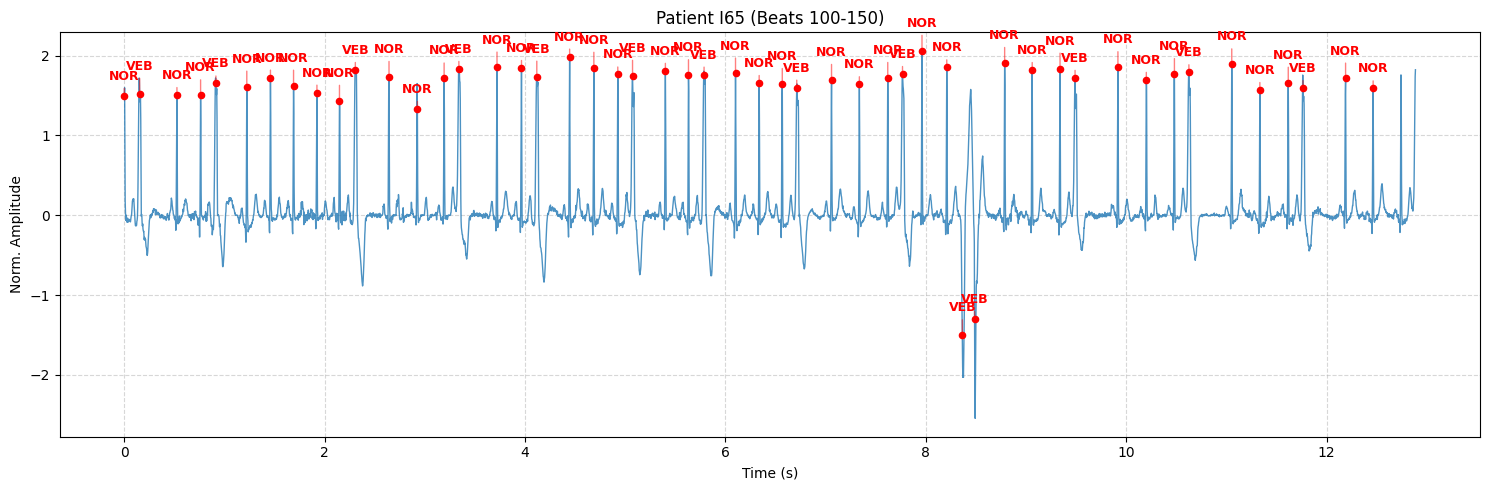

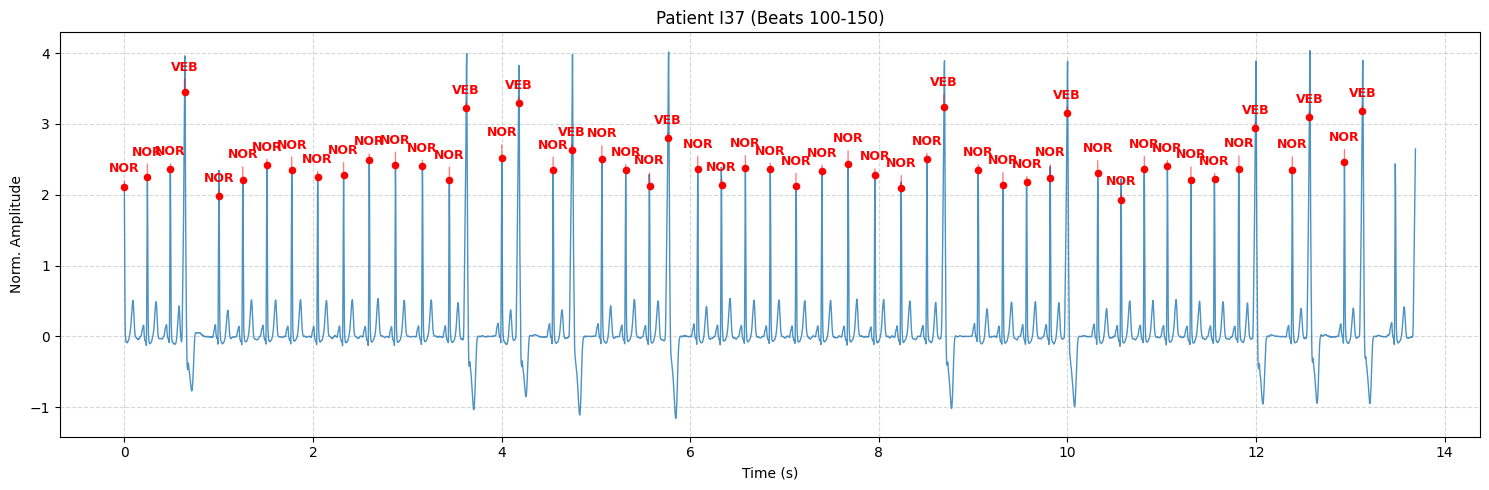

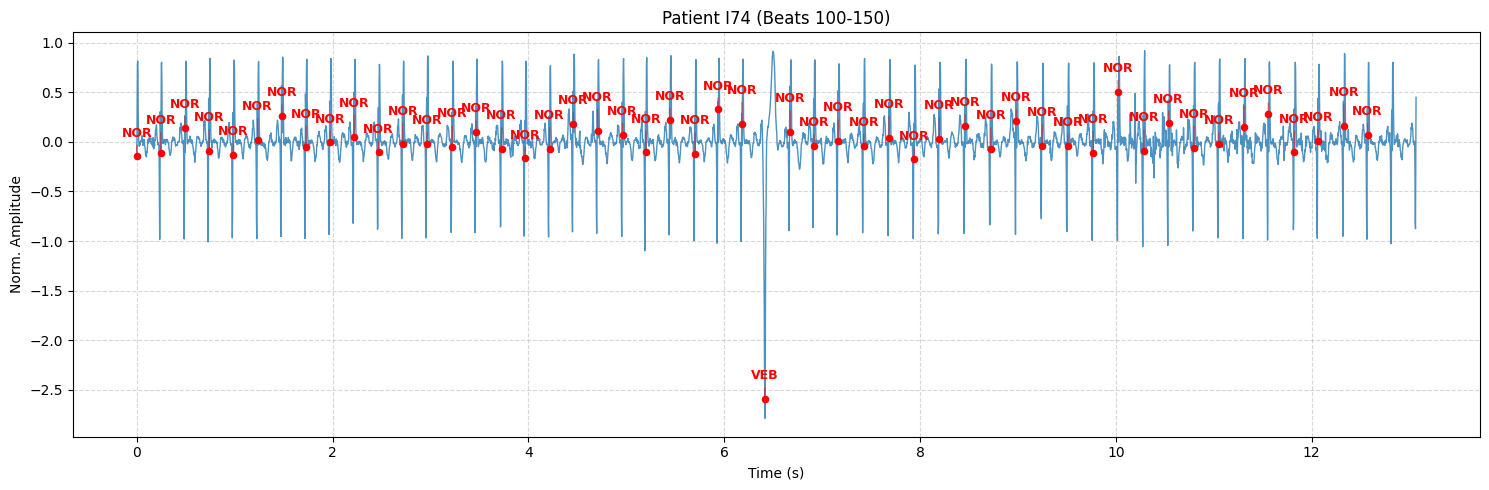

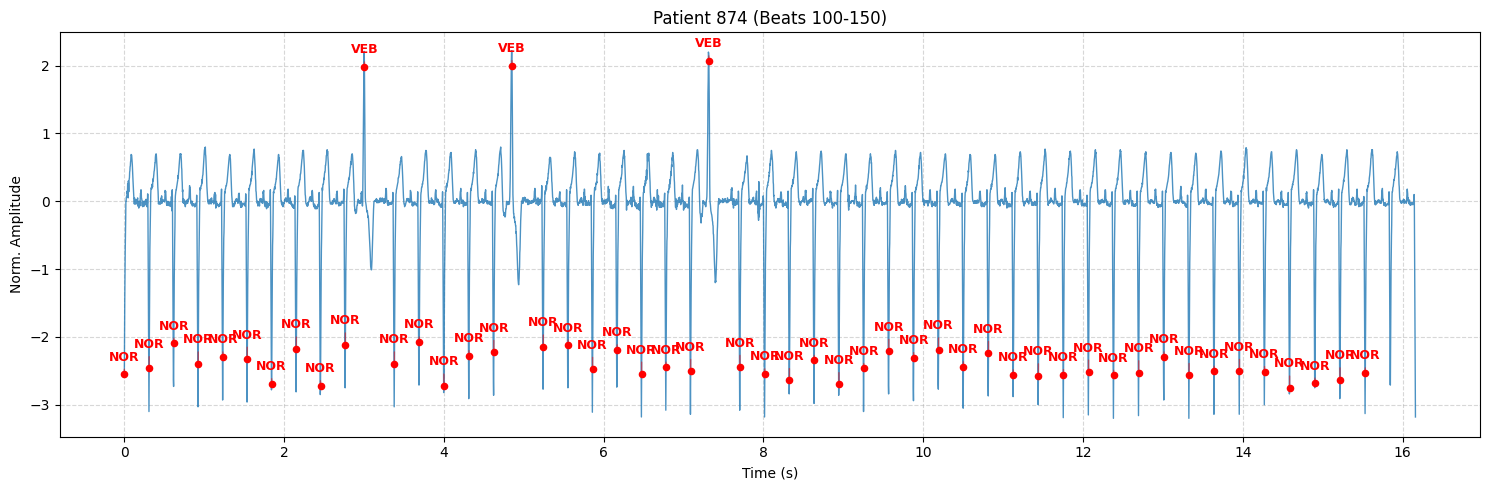

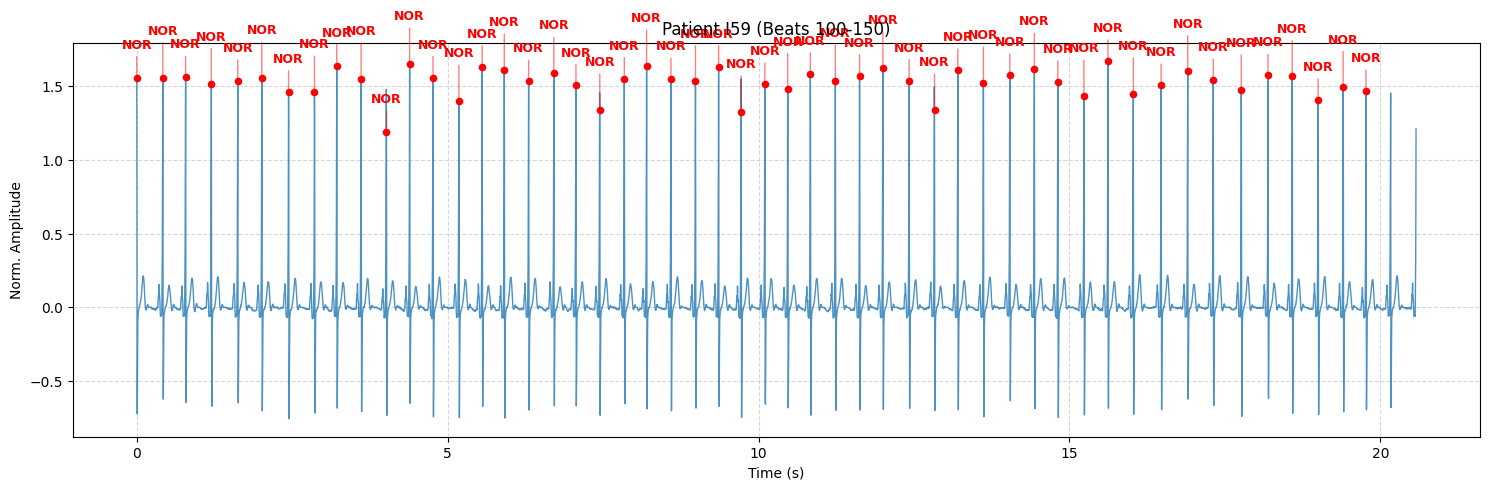

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clean_segment(signal, rel_locs, labels, title, fs=360):
    """
    Plots a clean ECG segment.
    - Hides 'N' labels to avoid clutter.
    - Offsets abnormal labels to prevent overlapping.
    """
    plt.figure(figsize=(15, 5))

    # Create time axis in seconds
    t = np.arange(len(signal)) / fs

    plt.plot(t, signal, color='#1f77b4', linewidth=1, alpha=0.8, label='ECG')

    # Filter valid indices within the segment range
    valid_mask = (rel_locs >= 0) & (rel_locs < len(signal))
    valid_locs = rel_locs[valid_mask].astype(int)
    valid_lbls = np.array(labels)[valid_mask]

    plt.scatter(t[valid_locs], signal[valid_locs], c='red', s=20, zorder=3)

    # Annotate Labels (Only abnormalities)
    for i, (idx, lbl) in enumerate(zip(valid_locs, valid_lbls)):
        if lbl == 'N':
            continue # Skip normal beats to reduce clutter

        # Stagger height to avoid text overlap
        height_offset = 0.2 + (i % 2) * 0.1

        plt.annotate(lbl,
                     xy=(t[idx], signal[idx]),
                     xytext=(t[idx], signal[idx] + height_offset),
                     arrowprops=dict(arrowstyle="-", color='red', alpha=0.5),
                     color='red', fontsize=9, fontweight='bold', ha='center')

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Norm. Amplitude")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Configuration
FS = 360  # Sampling frequency
BEAT_START, BEAT_END = 100, 150 # Range of beats to plot

patient_ids = list(set([r['patient_id'] for r in dataset['train']]))[:5]

for pid in patient_ids:
    # Fetch record
    record = [r for r in dataset['train'] if r['patient_id'] == pid][0]

    # Extract data
    full_signal = np.array(record['signal'])
    all_locs = np.array(record['beat_locs'])
    all_labels = np.array(record['beat_labels'])

    if len(all_locs) < BEAT_END + 5: continue

    # Slicing the segment (add buffer +2 beats to show full wave)
    start_sample = all_locs[BEAT_START]
    end_sample = all_locs[BEAT_END + 2]

    segment_signal = full_signal[start_sample:end_sample]

    # Adjust locations relative to segment start
    segment_locs = all_locs[BEAT_START:BEAT_END+1] - start_sample
    segment_labels = [idx_to_class[str(l)] for l in all_labels[BEAT_START:BEAT_END+1]]

    plot_clean_segment(segment_signal, segment_locs, segment_labels,
                       title=f'Patient {pid} (Beats {BEAT_START}-{BEAT_END})', fs=FS)

Across the five example patients, the 50-beat segments show predominantly regular normal (NOR) beats, with occasional SVEB/VEB beats that stand out through altered morphology and larger or inverted peaks.

<br>

2. **Construct the beat-level dataset**

In [ ]:
# Build aligned lists of beat waveforms and labels

all_beats = []
all_labels = []

for record in dataset['train']:
    signal = np.array(record['signal'])
    beat_locs = np.array(record['beat_locs'])

    beats = split_by_beat(signal, beat_locs)
    all_beats.extend(beats)
    all_labels.extend(record['beat_labels'])

print(f"Total beats: {len(all_beats)}")
print(f"Total labels: {len(all_labels)}")

Total beats: 461216
Total labels: 461216


All the heartbeats of the patients were collected together with their corresponding labels, and finally a complete dataset was obtained in which each heartbeat was successfully aligned and counted.

<br>

3. **Apply a simple pre-processing filter**  

In [ ]:
# Filter beats with physiologically implausible durations
# Min: 32 samples (240 bpm max), Max: 256 samples (30 bpm min)

MIN_LEN = 32   # 128 Hz * 60 / 240
MAX_LEN = 256  # 128 Hz * 60 / 30

filtered_beats = []
filtered_labels = []

for beat, label in zip(all_beats, all_labels):
    if MIN_LEN <= len(beat) <= MAX_LEN:
        filtered_beats.append(beat)
        filtered_labels.append(label)

print(f"Before: {len(all_beats)}, After: {len(filtered_beats)}, Removed: {len(all_beats)-len(filtered_beats)}")

Before: 461216, After: 460885, Removed: 331


The code filters the data within the range of physiologically feasible heartbeats and removes the unreasonable segments.

<br>

4. **Plot summary statistics**

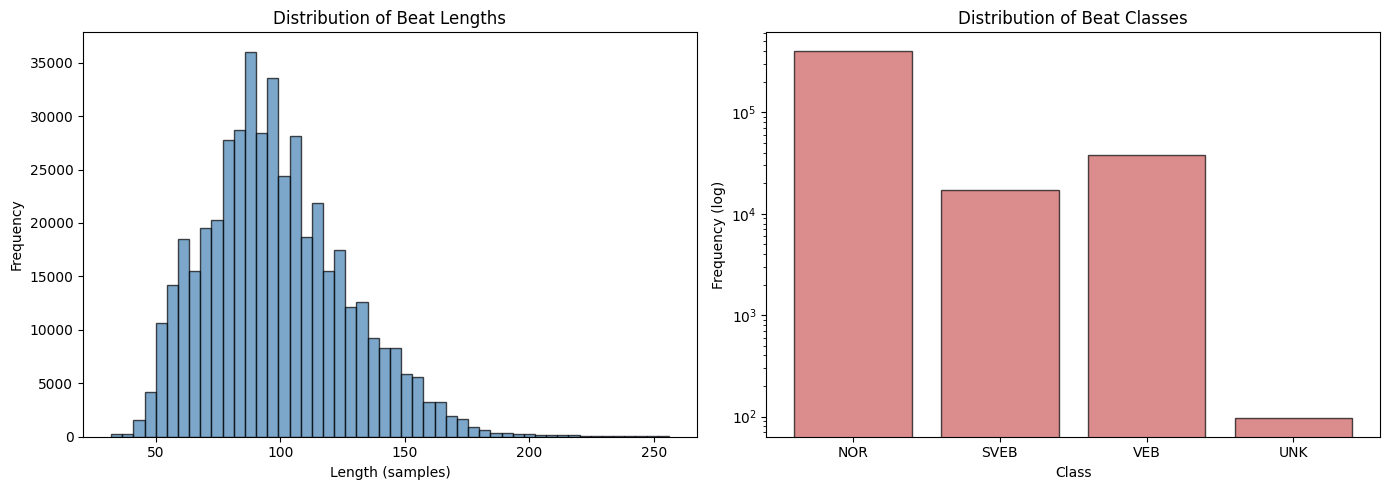

NOR: 405489 (87.98%)
SVEB: 17300 (3.75%)
VEB: 38000 (8.25%)
UNK: 96 (0.02%)


In [ ]:
# Plot distribution of beat lengths and class labels

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Beat length distribution
beat_lengths = [len(b) for b in filtered_beats]
axes[0].hist(beat_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Beat Lengths')
axes[0].set_xlabel('Length (samples)')
axes[0].set_ylabel('Frequency')

# Class distribution
class_counts = Counter(filtered_labels)
classes = sorted(class_counts.keys())
names = [idx_to_class[str(c)] for c in classes]
counts = [class_counts[c] for c in classes]

axes[1].bar(names, counts, color='indianred', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Beat Classes')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Print class percentages
for c in classes:
    print(f"{idx_to_class[str(c)]}: {class_counts[c]} ({100*class_counts[c]/len(filtered_labels):.2f}%)")

The heartbeats are mostly concentrated within the range of approximately 80 to 120 sampling points. The category distribution shows that normal heartbeats are clearly dominant (about 88%), while SVEB and VEB belong to the typical minority category, presenting a significant data imbalance.

<br><br>

## 2.B) Classification and Anomaly Detection

In this part you will build a supervised **beat-level classifier** using the segmented beats prepared in Part 2.A. Each beat is treated as an individual sample with a label in the simplified index space (0–4). Key points to consider:

- You should drop all beats with a label of **3** and only train the classifier for labels **0**, **1** and **2**. This will make the training easier, given the significant class imbalance.

- Beats naturally vary in duration, so you must decide how to convert them into a consistent representation suitable for a model. You are free to choose any reasonable approach; at the simplest level, you may choose to zero-pad beats to a fixed length, but more refined strategies are also acceptable.

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, the train/validation splits, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem.

- As established in Part 2.A, the dataset is **heavily imbalanced**, with normal beats dominating the distribution. This affects both training and evaluation: models that ignore imbalance tend to overfit normal beats while failing on minority abnormal classes. **Strong solutions will address imbalance explicitly and will aim to produce models that perform reliably across all classes, not only the majority one.** You are, therefore, required to report each validation metric twice: one for normal (0) and one for abnormal (1-2), separately.

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [ ]:
# DATA PREPROCESSING
# Remove beats with label 3 (UNK) - only keep labels 0, 1, 2
beats_clean = []
labels_clean = []

for beat, label in zip(filtered_beats, filtered_labels):
    if label != 3:
        beats_clean.append(beat)
        labels_clean.append(label)

print(f"After removing UNK (label 3): {len(beats_clean)} beats")
print(f"Class distribution: {Counter(labels_clean)}")


# Zero-pad all beats to fixed length (256 samples)
MAX_LEN = 256

def pad_beat(beat, max_len=256):
    """Pad beat to fixed length with zeros, or truncate if too long."""
    if len(beat) >= max_len:
        return np.array(beat[:max_len])
    return np.pad(beat, (0, max_len - len(beat)), mode='constant')

X = np.array([pad_beat(b, MAX_LEN) for b in beats_clean])
y = np.array(labels_clean)

#Z-Score Standardization.
mean_val = X.mean()
std_val = X.std()
X = (X - mean_val) / (std_val + 1e-8)

print(f"Normalization Stats -> Mean: {X.mean():.4f}, Std: {X.std():.4f}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train/Val split using StratifiedShuffleSplit to maintain class ratio
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(X, y))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f"Train: {len(X_train)}, Val: {len(X_val)}")
print(f"Train distribution: {Counter(y_train)}")
print(f"Val distribution: {Counter(y_val)}")


# Convert to PyTorch tensors
# Shape: (N, seq_len, input_size) for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_t, y_val_t),
    batch_size=BATCH_SIZE, shuffle=False
)

After removing UNK (label 3): 460789 beats
Class distribution: Counter({0: 405489, 2: 38000, 1: 17300})
Normalization Stats -> Mean: 0.0000, Std: 1.0000
X shape: (460789, 256), y shape: (460789,)
Train: 368631, Val: 92158
Train distribution: Counter({np.int64(0): 324391, np.int64(2): 30400, np.int64(1): 13840})
Val distribution: Counter({np.int64(0): 81098, np.int64(2): 7600, np.int64(1): 3460})


In [ ]:
class FocalLoss(torch.nn.Module):
    """
    Focal Loss: FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    - alpha: class weights
    - gamma: focusing parameter (default=2)
    """
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.alpha is not None:
            loss = self.alpha[targets] * loss
        return loss.mean()

Implementing Focal Loss with category weights, which is used to reduce the influence of easily classifiable samples and enhance the learning of minority classes.

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    Bidirectional LSTM Classifier for time-series data (e.g., ECG beats).
    It captures context from both past and future time steps for better feature extraction.
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, num_classes=3):
        super().__init__()

        # Store hidden_size as a class attribute so it can be used for slicing in forward()
        self.hidden_size = hidden_size

        # Define the LSTM layer
        # bidirectional=True doubles the output features (hidden_size * 2)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Fully connected layers
        # Input size is hidden_size * 2 because we concatenate forward and backward states
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through LSTM layers
        # out shape: (batch_size, seq_len, hidden_size * 2)
        out, _ = self.lstm(x)

        # Extract the final hidden state from the Forward direction (last timestep)
        out_fwd = out[:, -1, :self.hidden_size]
        out_bwd = out[:, 0, self.hidden_size:]

        # Concatenate both states to get the full context representation
        combined = torch.cat((out_fwd, out_bwd), dim=1)

        # Pass through the classification head
        x = self.dropout(self.relu(self.fc1(combined)))
        return self.fc2(x)

The parameter settings of this LSTM adopt a structure of bidirectional, two layers, 64 hidden units, and an input dimension of 1, which is used to simultaneously capture the forward and backward features of the time series, thereby better identifying the ECG cardiac rhythm patterns.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = LSTMClassifier().to(device)

# Class weights for Focal Loss (inverse frequency)
counts = Counter(y_train)
total = sum(counts.values())
alpha = torch.tensor([total/(3*counts[i]) for i in range(3)], dtype=torch.float32).to(device)
print(f"Class weights: {alpha}")

criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)




Device: cuda
Class weights: tensor([0.3788, 8.8784, 4.0420], device='cuda:0')


In [ ]:
NUM_EPOCHS = 50
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate
    model.eval()
    val_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(yb.cpu().numpy())

    # Record metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(accuracy_score(targets, preds))

    scheduler.step(history['val_loss'][-1])

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Train Loss: {history['train_loss'][-1]:.4f} | "
              f"Val Loss: {history['val_loss'][-1]:.4f} | "
              f"Val Acc: {history['val_acc'][-1]:.4f}")


Epoch 5/50 | Train Loss: 0.0691 | Val Loss: 0.0648 | Val Acc: 0.9364
Epoch 10/50 | Train Loss: 0.0566 | Val Loss: 0.0593 | Val Acc: 0.9498
Epoch 15/50 | Train Loss: 0.0505 | Val Loss: 0.0582 | Val Acc: 0.9455
Epoch 20/50 | Train Loss: 0.0453 | Val Loss: 0.0553 | Val Acc: 0.9550
Epoch 25/50 | Train Loss: 0.0409 | Val Loss: 0.0567 | Val Acc: 0.9569
Epoch 30/50 | Train Loss: 0.0377 | Val Loss: 0.0593 | Val Acc: 0.9257
Epoch 35/50 | Train Loss: 0.0327 | Val Loss: 0.0533 | Val Acc: 0.9512
Epoch 40/50 | Train Loss: 0.0297 | Val Loss: 0.0565 | Val Acc: 0.9601
Epoch 45/50 | Train Loss: 0.0282 | Val Loss: 0.0563 | Val Acc: 0.9608
Epoch 50/50 | Train Loss: 0.0275 | Val Loss: 0.0574 | Val Acc: 0.9607


Train the model and print the effect parameters of each training round

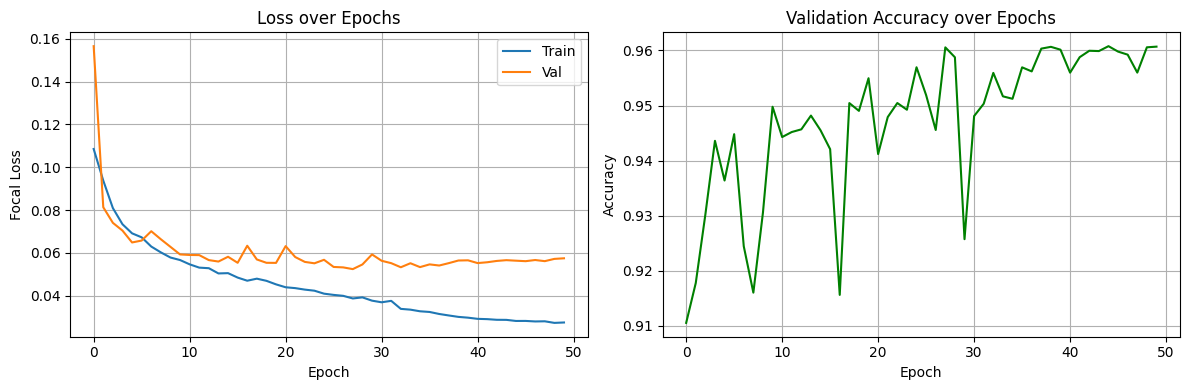

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss Curves
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Focal Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy Curves
axes[1].plot(history['val_acc'], color='green')
axes[1].set_title('Validation Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Loss trend and accuracy change graph

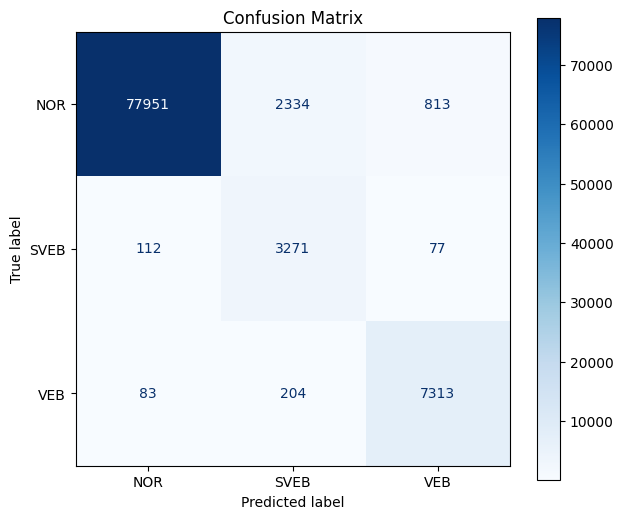

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
model.eval()

all_preds, all_targets = [], []

# Disable gradient calculation
with torch.no_grad():
    for xb, yb in val_loader:
        # Move inputs to the configured device (GPU or CPU)
        xb = xb.to(device)

        # Forward pass: Compute model predictions
        out = model(xb)

        # Get the predicted class index
        all_preds.extend(out.argmax(1).cpu().numpy())

        # Store the ground truth labels for comparison later
        all_targets.extend(yb.numpy())

# Convert lists to numpy arrays for efficient processing with sklearn metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Confusion Matrix (3-class)
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay(cm, display_labels=['NOR', 'SVEB', 'VEB']).plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')
plt.show()

The model performed robustly on the validation set: The normal heartbeats (NOR) prediction was very accurate, with 77,951 cases correctly classified; at the same time, the model was also able to effectively distinguish abnormal heartbeats, among which SVEB was correct for 3,271 cases and VEB for 7,313 cases. There was only a small amount of confusion between SVEB and VEB.

PER-CLASS PERFORMANCE (Detailed)
              precision    recall  f1-score   support

         NOR     0.9975    0.9612    0.9790     81098
        SVEB     0.5631    0.9454    0.7058      3460
         VEB     0.8915    0.9622    0.9255      7600

    accuracy                         0.9607     92158
   macro avg     0.8174    0.9563    0.8701     92158
weighted avg     0.9725    0.9607    0.9643     92158

Normal & Abnormal
              precision    recall  f1-score   support

      Normal     0.9975    0.9612    0.9790     81098
    Abnormal     0.7754    0.9824    0.8667     11060

    accuracy                         0.9637     92158
   macro avg     0.8865    0.9718    0.9229     92158
weighted avg     0.9709    0.9637    0.9655     92158



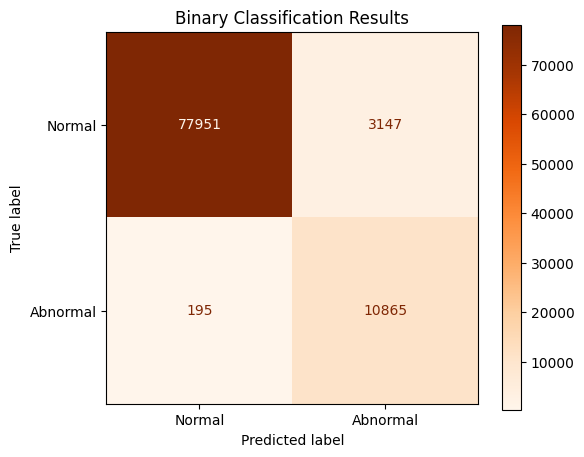

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Detailed Per-Class Metrics (N, SVEB, VEB)
# This replaces all the manual calculations for individual classes
print("PER-CLASS PERFORMANCE (Detailed)")
print(classification_report(all_targets, all_preds, target_names=['NOR', 'SVEB', 'VEB'], digits=4))

# Aggregated Binary Metrics (Normal vs Abnormal)
print("Normal & Abnormal")

# Convert to binary: 0 stays 0, (1 & 2) become 1
binary_targets = (all_targets > 0).astype(int)
binary_preds = (all_preds > 0).astype(int)

# Print binary report
print(classification_report(binary_targets, binary_preds, target_names=['Normal', 'Abnormal'], digits=4))

# Plot Binary Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_bin = confusion_matrix(binary_targets, binary_preds)
ConfusionMatrixDisplay(cm_bin, display_labels=['Normal', 'Abnormal']).plot(ax=ax, cmap='Oranges')
plt.title('Binary Classification Results')
plt.show()

The model performed exceptionally well in both three-class and two-class tasks:

The normal heartbeats (NOR) maintained an extremely high accuracy (precision = 0.9975), while the two abnormal categories showed stable performance.

 VEB performed robustly (f1 = 0.9255), while SVEB was very excellent in recall (0.9454) but had a relatively lower precision (0.5631), indicating that some SVEB were still misclassified;

  In the two-class task, the model could robustly distinguish normal (0) from abnormal (1) heartbeats with an overall accuracy of 0.9637.
  
  The recall of the abnormal category was as high as 0.9824, demonstrating that the model has a very strong detection ability for abnormal heartbeats.

<br><br>

## 2.C) Discussion (max 250 words)

Reflect critically on your solution to Part 2.B. In your discussion, address the following points:

1. **Modelling choices**

   Explain the main decisions behind your model design(s) and why you believe these choices are suitable for this task.

2. **Performance and validation**
   
   Interpret your model’s performance on normal versus abnormal beats using the evaluation metrics you selected. Comment on how class imbalance affected the results and what strategies you have sought to mitigate its impact.

3. **Limitations and improvements**
   
   Identify the main limitations of your approach and outline specific steps that could meaningfully improve performance. You may refer to architectural changes, alternative representations, different imbalance-handling strategies, or improved validation schemes.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

## 1. Modelling Choices

I selected a **Bidirectional LSTM** architecture because ECG signals are inherently sequential time-series data where temporal dependencies are critical for beat classification. The bidirectional structure captures both past and future context within each beat, enabling the model to recognise morphological patterns such as QRS complex shape and R-R interval variations. Z-score normalisation and zero-padding to 256 samples ensured consistent input representation.

For the loss function, I initially employed **weighted cross-entropy** to address class imbalance. However, this yielded poor SVEB recall (~0.1), as the model still favoured majority-class predictions. I subsequently adopted **Focal Loss** (Lin et al., 2017), which down-weights easily classified samples and focuses learning on hard examples. This substantially improved minority-class detection.

## 2. Performance and Validation

The model achieved **96.07% overall accuracy** with strong performance across classes. Normal beats achieved high precision (0.9975) and recall (0.9612). VEB classification was robust (F1=0.9255), while SVEB showed excellent recall (0.9454) but lower precision (0.5631), indicating some normal beats were misclassified as SVEB. In binary evaluation (Normal vs Abnormal), abnormal recall reached **0.9824**, demonstrating effective anomaly detection. Focal Loss with class-weighted alpha successfully mitigated the severe imbalance (88% NOR vs 4% SVEB).

## 3. Limitations and Improvements

Key limitations include: (1) fixed-length padding may discard temporal information; (2) no patient-level split risks data leakage. Improvements could include **attention mechanisms** to highlight diagnostically relevant segments, **resampling or interpolation** instead of zero-padding, and **patient-stratified cross-validation** for more reliable generalisation estimates.



<br>

---

<br>